In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

torch.manual_seed(42)
np.random.seed(42)

In [12]:
class Sin_Fc(nn.Module):
    def __init__(self, n_ne_l1, n_ne_l2, n_ne_l3=None) -> None:
        super().__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(1, n_ne_l1),
            nn.Tanh(),
            nn.Linear(n_ne_l1, n_ne_l2),
            nn.Tanh(),
            
            # nn.Linear(n_ne_l2, n_ne_l3),
            # nn.Tanh(),
            # nn.Linear(n_ne_l3, 1),
            # nn.Tanh(),

            nn.Linear(n_ne_l2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.fc1(x)
        return out


In [3]:
DATASET_PATH = './sin_df.csv'
df = pd.read_csv(DATASET_PATH)

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [4]:
class SinDataset(Dataset):
    def __init__(self, df) -> None:
        super().__init__()
        self.df = df.reset_index(drop=True)

    def __getitem__(self, index):
        num = self.df['nums'][index]
        sin = self.df['sins'][index]

        return torch.tensor([num], dtype=torch.float32), torch.tensor([sin], dtype=torch.float32)
    
    def __len__(self):
        return len(self.df)


In [5]:
train_ds = SinDataset(train_df)
val_ds = SinDataset(val_df)
test_ds = SinDataset(test_df)

train_dl = DataLoader(train_ds, batch_size=5, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=5, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=5, shuffle=True, drop_last=True)

In [6]:
len(train_ds), len(test_ds), len(val_ds)

(162, 20, 18)

In [7]:
nums, sins = next(iter(train_dl))
# nums, sins

In [8]:
def train_one_epoch(model, 
                    train_dl, 
                    loss_fn, 
                    optimizer, 
                    device):
    model.train()
    model.to(device)

    loss_train = 0
    for _, (nums, sins) in enumerate(train_dl):

        optimizer.zero_grad()

        nums = nums.to(device)
        sins = sins.to(device)

        outputs = model(nums)
        loss = loss_fn(outputs, sins)

        loss_train += loss.item()

        loss.backward()

        optimizer.step()

    return loss_train/len(train_dl)

def test_one_epoch(model, 
                    test_dl, 
                    loss_fn, 
                    device):
    model.eval()
    model.to(device)
    loss_val = 0

    with torch.inference_mode():
            
        for _, (nums, sins) in enumerate(test_dl):

            nums = nums.to(device)
            sins = sins.to(device)

            outputs = model(nums)
            loss = loss_fn(outputs, sins)

            loss_val += loss.item()

    return loss_val/len(test_dl)


def train(model,
          train_dl,
          test_dl,
          loss_fn, 
          optimizer, 
          device,
          epochs):
    
    results = {
        'train_loss':[],
        'test_loss':[]
    }
    
    for _ in range(epochs):

        train_loss = train_one_epoch(model=model,
                                     train_dl=train_dl,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     device=device)
        
        test_loss = test_one_epoch(model=model,
                                   test_dl=test_dl,
                                   loss_fn=loss_fn,
                                   device=device)
        
        results['train_loss'].append(train_loss)
        results['test_loss'].append(test_loss)

    return results
        

In [9]:
device = 'cpu'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.MSELoss()

In [13]:
# function to find best neurons_per_layer

def find_best_ne(n_ne_l1, n_ne_l2):
    '''gives the first and second layer num of neurons and train and test it .
       then return the results of each combinitions of that .
    ''' 
    final_resutls = []

    for i in range(10, n_ne_l1, 10):
        for j in range(10, n_ne_l2, 10):
            model = Sin_Fc(i, j)
            optimizer = torch.optim.Adam(params=model.parameters(), lr=.001)
            results = train(model=model,
                            train_dl=train_dl,
                            test_dl=val_dl,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device,
                            epochs=20)
            final_resutls.append({(i, j):results})

    return final_resutls

In [ ]:
# find the best pairs of my num_neurons for my first and second layer
ne_exp_list = find_best_ne(21, 21)

# save the final results for our neuron_per_layer expriments
with open('neuron_per_layer_results.txt', 'a') as file:
    print(ne_exp_list, file=file)

best_ne_per_layer = min(ne_exp_list, key=lambda x: x[list(x.keys())[0]]['test_loss'][-1])
best_ne_per_layer

In [15]:
# after finding best number for our first and second layer we should find best nums for third layer.
def find_best_third_ne(n_ne_l3):
    final_resutls = []
    for i in range(10, n_ne_l3, 10):
        model = Sin_Fc(10, 10, i) # our model with desired first and second ne nums and find third ne nums
        optimizer = torch.optim.Adam(params=model.parameters(), lr=.001)
        results = train(model=model,
                        train_dl=train_dl,
                        test_dl=val_dl,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        device=device,
                        epochs=20)
        final_resutls.append({(i):results})

    return final_resutls

In [16]:
# find the best number of third layer num_neurons 
third_ne_exp_list = find_best_third_ne(30)

# save the final results for our neuron_per_third_layer expriments
with open('ne_per_third_layer_results.txt', 'a') as file:
    print(third_ne_exp_list, file=file)

best_ne_per_third_layer = min(third_ne_exp_list, key=lambda x: x[list(x.keys())[0]]['test_loss'][-1])
# best_ne_per_third_layer

keys = [] # key of dict:the neuron number of our third layer
lowest_test_losses = [] # the test_loss of our correspond number of neurons

for dictionary in third_ne_exp_list:
    min_test_loss_key = min(dictionary, key=lambda k: dictionary[k]['test_loss'][-1])
    keys.append(min_test_loss_key)
    lowest_test_losses.append(dictionary[min_test_loss_key]['test_loss'][-1])

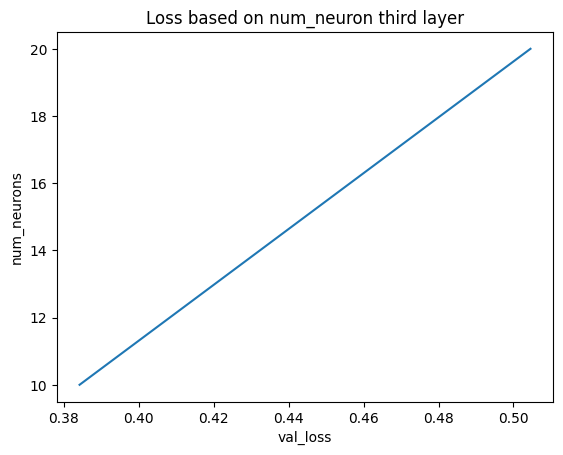

In [17]:
# plot loss curve based on num third layer neurons to find best number of neurons
plt.plot(lowest_test_losses, keys)

plt.title('Loss based on num_neuron third layer')
plt.ylabel('num_neurons')
plt.xlabel('val_loss');

In [18]:
# train model with best combination of neurons with big epochs for finding best lr rate. 
# we use random search for this goal
# functioc to find best lr. 
ne_layer_1 = 
ne_layer_2 = 
ne_layer_3 =

model = Sin_Fc(ne_layer_1, ne_layer_2, ne_layer_3) # our desired model

def find_best_lr(n_iter):
    '''n_iter: number of iteratins we want to find best lr .
    '''
    final_res_lr = []
    for _ in range(n_iter):

        lr = 10 ** ((-4 - 0) * torch.rand(1) + 0).item()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        # print(f'lr : {lr}')

        results = train(model=model,
                    train_dl=train_dl,
                    test_dl=val_dl,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    device=device,
                    epochs=200)
        final_res_lr.append({lr:results})
    
    return final_res_lr
    

In [22]:
n_lr_find = 2
lr_exp_list = find_best_lr(n_lr_find)
best_lr = min(lr_exp_list, key=lambda x: x[list(x.keys())[0]]['test_loss'][-1])
# best_lr

lrs = [] # key of dict:the lr 
losses_correspond_lr = [] # the test_loss with correspond lr

for dictionary in lr_exp_list:
    min_test_loss_key = min(dictionary, key=lambda k: dictionary[k]['test_loss'][-1])
    lrs.append(min_test_loss_key)
    losses_correspond_lr.append(dictionary[min_test_loss_key]['test_loss'][-1])

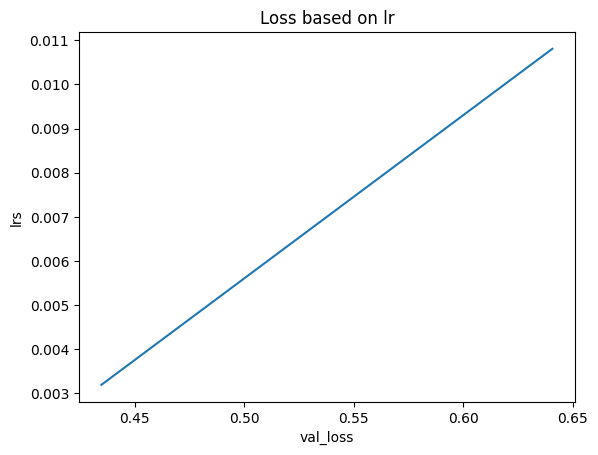

In [23]:
# plot loss curve based on lr to find best lr
plt.plot(losses_correspond_lr, lrs)

plt.title('Loss based on lr')
plt.ylabel('lrs')
plt.xlabel('val_loss');

In [ ]:
# train model with best neuron_per_layer and best lr. 
# final train
ne_layer_1 = 
ne_layer_2 = 
ne_layer_3 =

lr = 

model = Sin_Fc(ne_layer_1, ne_layer_2, ne_layer_3) # our desired model
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

results = train(model=model,
                train_dl=train_dl,
                test_dl=val_dl,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                epochs=20)

In [ ]:
# plot model results

In [ ]:
MODEL_PATH = "best_model.pth"
# torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
# initialize model and load pretrained model
# model = Sin_Fc(10, 10)

# model.load_state_dict(torch.load(MODEL_PATH))
# res = test_one_epoch(model=model, 
#                     test_dl=test_dl, 
#                     loss_fn=loss_fn, 
#                     device=device)
# res

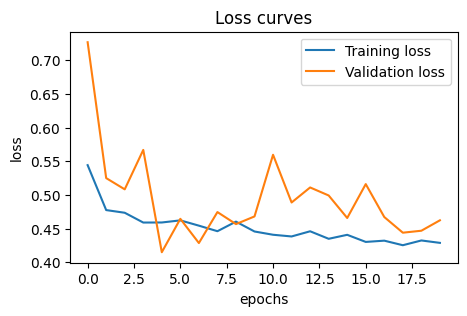

In [ ]:
fig, ax  = plt.subplots(1, 1, figsize=(5, 3))

ax.plot(results['train_loss'], label='Training loss')
ax.plot(results['test_loss'], label='Validation loss')

plt.title('Loss curves')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best');

In [ ]:
# just the report of losses with number of neurons 
# train and then final report